<a href="https://colab.research.google.com/github/FS-Tamim/LT-EDI-RANLP-2023/blob/main/XLMR-roberto-base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.7 MB/s eta 0:00:00


## Importing necessary packages

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [4]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading training data

In [6]:

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shared Tasl/train_data (1).csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 7,201



,PID,text,labels
4512,train_pid_4513,Why do I have so many mood swings? (28m) : Why...,moderate
4660,train_pid_4661,"I think I might kill myself, but I’m not scare...",moderate
1038,train_pid_1039,i'm always the bad guy. always. : life seems t...,moderate
4342,train_pid_4343,Someone kill me already : We’re moving and I a...,moderate
6555,train_pid_6556,I’ve lost so many of my close friends : The la...,not depression
239,train_pid_240,Bad things are coming : I recently started tak...,moderate
1606,train_pid_1607,23 feels like the new 88 : So I turned 23 toda...,not depression
2900,train_pid_2901,How do I force myself to care? : About myself?...,moderate
3340,train_pid_3341,"I don’t feel anything anymore. : A while ago, ...",moderate
2821,train_pid_2822,I really hate myself for the thing I did to my...,moderate


In [7]:
train_df

,PID,text,labels
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate
...,...,...,...
7196,train_pid_7197,Aren’t we all just tired? : I’ve been depresse...,severe
7197,train_pid_7198,NEED HELP COPING : I had my life pretty much f...,severe
7198,train_pid_7199,Qutting Zoloft Cold Turkey : I was on 75 mg se...,severe
7199,train_pid_7200,Crying : I’m coming off my antidepressants and...,severe


In [8]:
train_df['labels'].value_counts()

moderate          3678
not depression    2755
severe             768
Name: labels, dtype: int64

In [9]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [10]:
train_df['labels'].value_counts()

0    3678
1    2755
2     768
Name: labels, dtype: int64

### Loading `train_sentences` and `train_labels`

In [11]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [12]:
class_names = [
               'moderate','non depression','severe'
]

## Loading the validation data

In [13]:
# val_df_path = join(dataset_dir,'tamil_offensive_full_dev_corrected.csv')
# Load the dataset into a pandas dataframe.
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shared Tasl/dev_data.csv')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(val_df.shape[0]))

# Display 10 random rows from the data.
val_df.sample(10)

Number of training sentences: 3,245



,Pid,text,labels
1696,dev_pid_1697,Kill me : I’m going to die I can’t breathe. I ...,moderate
150,dev_pid_151,"I’ve failed myself, I’m 23 and have nothing go...",moderate
765,dev_pid_766,Questioning My Sanity : I've fallen into the u...,moderate
829,dev_pid_830,"Every day : Every day, i try to stay until the...",moderate
562,dev_pid_563,All I feel is negativity : An thing I do or th...,moderate
973,dev_pid_974,Depression is not something simple to get rid ...,moderate
39,dev_pid_40,Are there any subreddits where I can ask for d...,moderate
1597,dev_pid_1598,going to pretend someone cares briefly : it is...,moderate
1988,dev_pid_1989,Can I talk with someone : School just got shut...,moderate
2695,dev_pid_2696,"The FIRST cut is the HARDEST, the LAST ONE is ...",not depression


In [14]:
val_df['labels'].value_counts()

moderate          2169
not depression     848
severe             228
Name: labels, dtype: int64

In [15]:
val_df['labels'] = le.transform(val_df['labels'])

In [16]:

val_df['labels'].value_counts()

0    2169
1     848
2     228
Name: labels, dtype: int64

### Loading `val_sentences` and `val_labels`

In [17]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

## Helper Functions

#### 1) Update Interval Function

In [18]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [19]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [20]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [21]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [22]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [23]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [24]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [25]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [26]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [27]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [28]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [29]:
# model_name = 'bert-base-multilingual-cased'
model_name='xlm-roberta-base'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading xlm-roberta-base tokenizer...


In [30]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

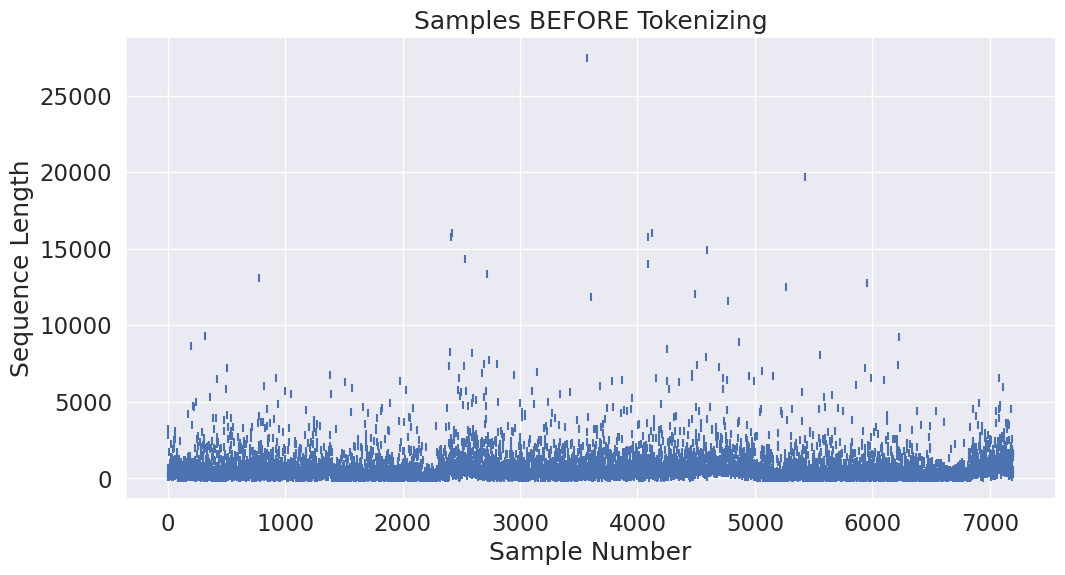

In [31]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [32]:
max_input_length = 400

In [33]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 7,201 training samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
  Tokenized 7,000 samples.
DONE.
     7,201 samples


In [34]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

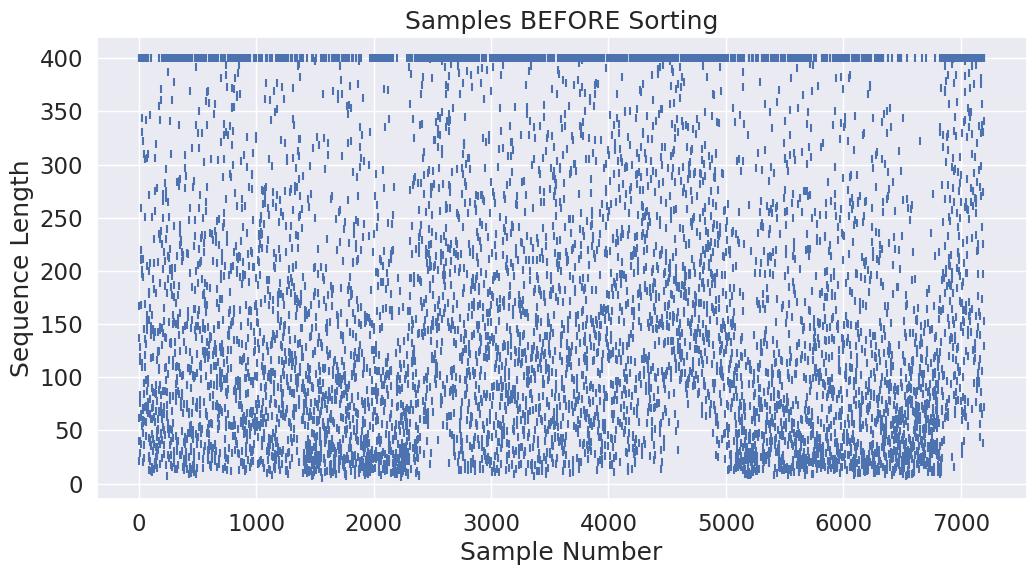

In [35]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [36]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [37]:
train_samples[0:5]

[([0, 48962, 152, 24129, 2], 1),
 ([0, 133903, 214, 179459, 152, 2], 1),
 ([0, 40878, 26818, 152, 40878, 26818, 2], 0),
 ([0, 563, 7237, 42551, 538, 152, 2], 1),
 ([0, 171581, 103049, 7, 152, 31124, 2], 1)]

In [38]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 5
Longest sample: 400


In [39]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

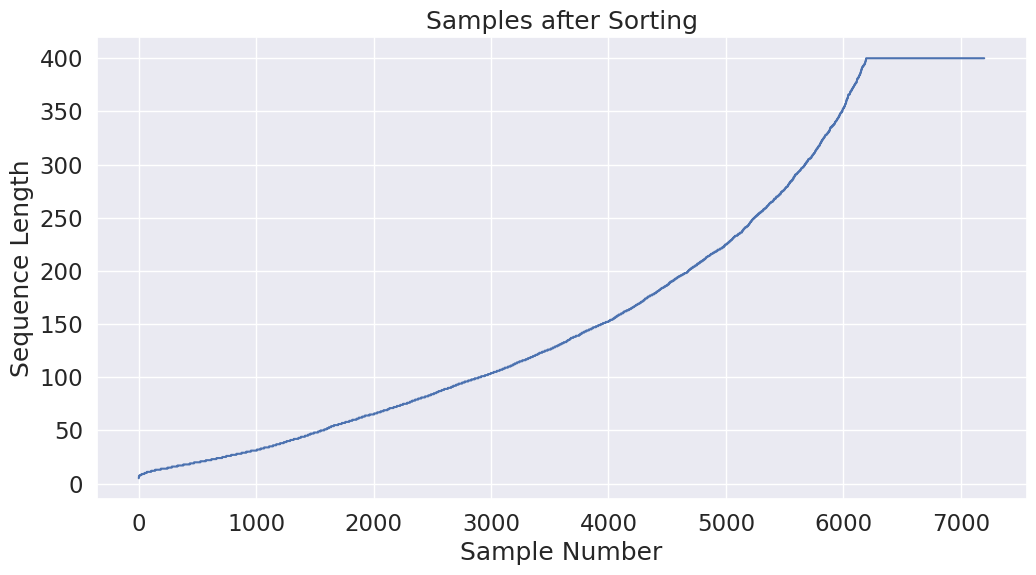

In [40]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [41]:
train_samples[0]

([0, 48962, 152, 24129, 2], 1)

In [42]:
batch_size = 16

In [43]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.

  DONE - 451 batches.


In [44]:
print(batch_ordered_sentences[0])

[[0, 87, 2301, 26, 18, 28219, 152, 87, 6165, 76, 67153, 35978, 1284, 87, 23742, 26, 18, 6637, 52, 568, 5608, 19, 26, 18, 54, 442, 974, 4966, 87, 2301, 26, 18, 6165, 76, 6867, 136, 17, 765, 110, 48302, 47, 6867, 221, 3642, 70, 33600, 444, 87, 132294, 2046, 11522, 2174, 87, 2301, 26, 18, 765, 70, 98365, 47, 2046, 11522, 32, 87, 26, 39, 98, 2874, 112, 11856, 10840, 136, 87, 26, 39, 134598, 47, 738, 47, 6, 106864, 1284, 87, 26, 39, 959, 7730, 6637, 87, 2301, 26, 18, 765, 70, 48302, 47, 54, 221, 5, 11249, 831, 22008, 1884, 163, 2750, 26, 7, 221, 8, 11856, 297, 450, 1836, 765, 110, 15673, 111, 141753, 11522, 136, 765, 110, 98365, 47, 2046, 11522, 20653, 2046, 11522, 5, 3347, 3642, 831, 3395, 41206, 2856, 959, 47, 67153, 61261, 3229, 2685, 26, 7, 110, 120976, 18227, 111, 20949, 10, 11522, 6897, 5, 87, 26, 39, 20653, 6183, 17946, 442, 56112, 26, 18, 68186, 71, 47, 67153, 31949, 5, 4263, 23, 450, 3917, 87, 26, 39, 132294, 186, 17723, 7068, 2633, 163, 186, 5, 41021, 2750, 3444, 163, 47, 24765, 9

In [45]:
batch_ordered_labels[0]

[2, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1]

### Padding

In [46]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [47]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 2,880,400
  Smart Batching: 1,243,861  (56.8% less)


## Load the model configuration from the transformers library using AutoConfig

In [48]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'> 



In [49]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_

In [50]:
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

## Load the model from the transformers library using AutoModel

In [51]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Model type: <class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaModel'>


In [52]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [53]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [54]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [55]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [56]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [57]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [58]:
# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = {
    'epoch':[],
    'train_loss':[],
    'Training Time':[],
    'val_loss':[],
    'Validation Time':[],
    'train_acc':[],
    'val_acc':[]
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)

    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = output.loss
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)

    training_accuracy = check_accuracy(predictions,true_labels)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(training_accuracy))
    print("  Training epoch took: {:}".format(training_time))

    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)
    val_loss,val_accuracy,validation_time = eval_model(model,py_inputs, py_attn_masks, py_labels)
    # Record all statistics from this epoch.

    print("")
    print("  Average validation loss: {0:.2f}".format(val_loss))
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation epoch took: {:}".format(validation_time))


    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training on 451 batches...
  Batch      50  of      451.    Elapsed: 0:00:25.  Remaining: 0:03:22
  Batch     100  of      451.    Elapsed: 0:00:52.  Remaining: 0:03:01
  Batch     150  of      451.    Elapsed: 0:01:19.  Remaining: 0:02:39
  Batch     200  of      451.    Elapsed: 0:01:46.  Remaining: 0:02:13
  Batch     250  of      451.    Elapsed: 0:02:08.  Remaining: 0:01:43
  Batch     300  of      451.    Elapsed: 0:02:32.  Remaining: 0:01:17
  Batch     350  of      451.    Elapsed: 0:03:00.  Remaining: 0:00:52
  Batch     400  of      451.    Elapsed: 0:03:28.  Remaining: 0:00:27
  Batch     450  of      451.    Elapsed: 0:03:59.  Remaining: 0:00:01

  Average training loss: 0.91
  Training Accuracy: 0.57
  Training epoch took: 0:03:59
Creating Smart Batches from 3,245 examples with batch size 16...

Tokenizing 3,245 samples...
  Tokenized 0 samples.
  Tokenized 300 samples.
  Tokenized 600 samples.
  Tokenized 900 samples.
  Tokenized 1,200 sampl

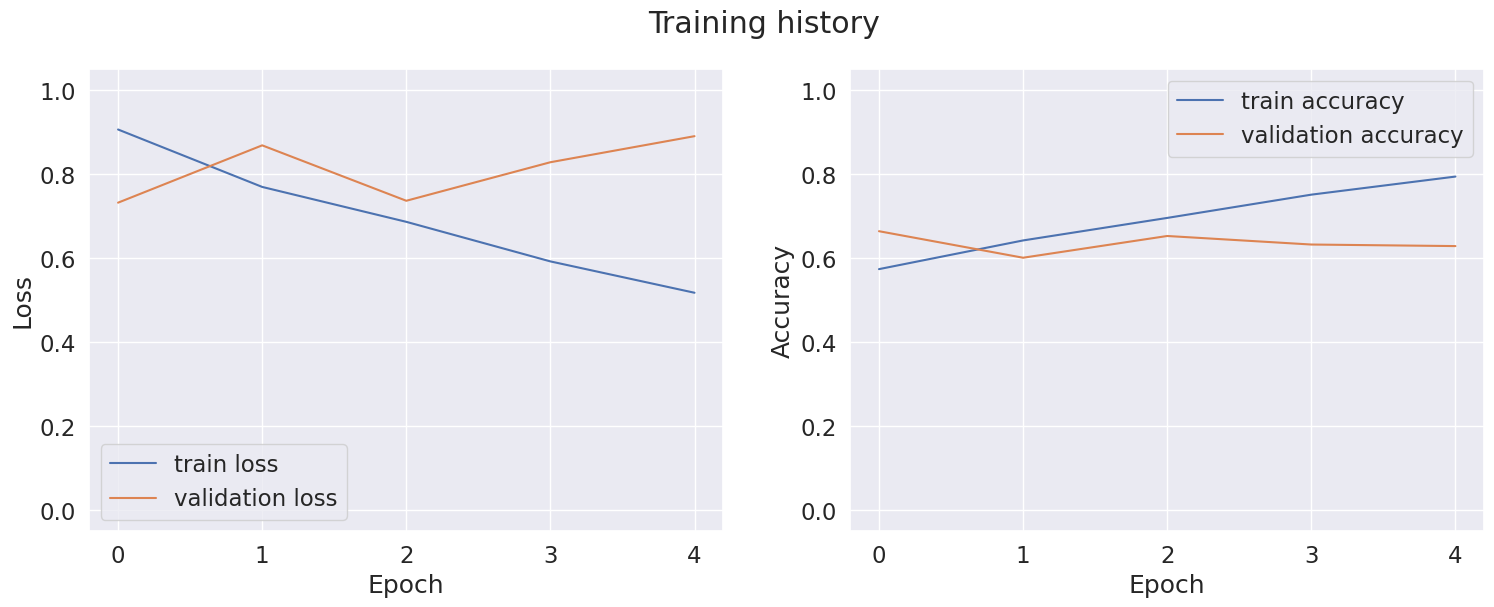

In [59]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [60]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 7,201 examples with batch size 16...

Tokenizing 7,201 samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
  Tokenized 7,000 samples.
DONE.
     7,201 samples

     7,201 samples after sorting

Creating batches of size 16...

  DONE - Selected 451 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 451 test batches...
  Batch      50  of      451.    Elapsed: 0:00:08.  Remaining: 0:01:05
  Batch     100  of      451.    Elapsed: 0:00:16.  Remaining: 0:00:58
  Batch     150  of      451.    Elapsed: 0:00:26.  Remaining: 0:00:51
  Batch     200  of      451.    Elapsed: 0:00:33.  Remaining: 0:00:42
  Batch     250  of      451.    Elapsed: 0:00:42.  Remaining: 0:00:34
  Batch     300  of      451.    Elapsed: 0

In [61]:
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

      moderate       0.83      0.90      0.86      3678
non depression       0.88      0.81      0.85      2755
        severe       0.84      0.74      0.79       768

      accuracy                           0.85      7201
     macro avg       0.85      0.82      0.83      7201
  weighted avg       0.85      0.85      0.85      7201



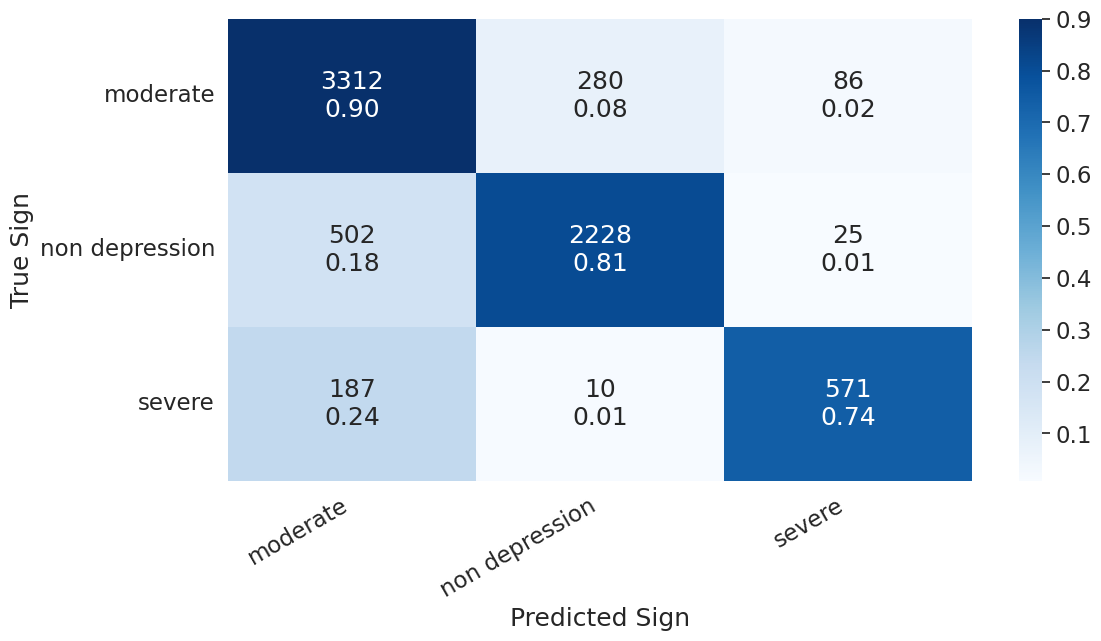

In [62]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [63]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 3,245 examples with batch size 16...

Tokenizing 3,245 samples...
  Tokenized 0 samples.
  Tokenized 300 samples.
  Tokenized 600 samples.
  Tokenized 900 samples.
  Tokenized 1,200 samples.
  Tokenized 1,500 samples.
  Tokenized 1,800 samples.
  Tokenized 2,100 samples.
  Tokenized 2,400 samples.
  Tokenized 2,700 samples.
  Tokenized 3,000 samples.
DONE.
     3,245 samples

     3,245 samples after sorting

Creating batches of size 16...

  DONE - Selected 203 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 203 test batches...
  Batch      20  of      203.    Elapsed: 0:00:03.  Remaining: 0:00:29
  Batch      40  of      203.    Elapsed: 0:00:06.  Remaining: 0:00:26
  Batch      60  of      203.    Elapsed: 0:00:09.  Remaining: 0:00:22
  Batch      80  of      203.    Elapsed: 0:00:12.  Remaining: 0:00:18
  Batch     100  of      203.    Elapsed: 0:00:16.  Remaining: 0:00:16
  Batch     120  of      203.    Elapsed: 0:00:

In [64]:
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

      moderate       0.76      0.67      0.71      2169
non depression       0.44      0.55      0.49       848
        severe       0.44      0.50      0.47       228

      accuracy                           0.63      3245
     macro avg       0.55      0.57      0.56      3245
  weighted avg       0.65      0.63      0.64      3245



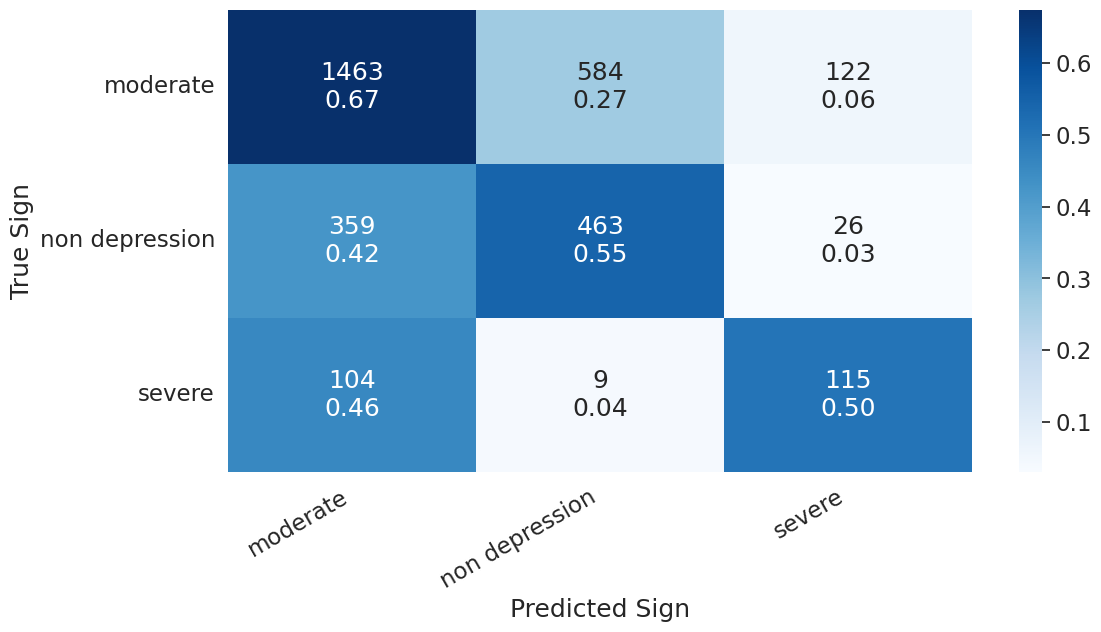

In [65]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [66]:
# test_df_path = join(dataset_dir,'tamil_offensive_full_test.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shared Tasl/Test_data_with_labels - test_data.csv')

In [67]:
test_df

,Pid,Text data,Label
0,test_id_1,"This is me. Don鈥檛 get me wrong, it鈥檚 better th...",moderate
1,test_id_2,I hate that people don鈥檛 understand that i don...,severe
2,test_id_3,"But here I am, 24 years old man and doing exac...",moderate
3,test_id_4,I鈥檓 trapped inside. Does anyone else get that ...,moderate
4,test_id_5,I read a lot of posts on here of people strugg...,moderate
...,...,...,...
494,test_id_495,I'm 14\nmy mom doesn't take my mental health s...,severe
495,test_id_496,I was quite shocked at their reactions. I sort...,moderate
496,test_id_497,Lying on my bed..... fantasising another life ...,not depression
497,test_id_498,"I was bullied in elementary school, and I alwa...",moderate


## Loading `test_sentences`

In [68]:
test_sentences = test_df['Text data'].values
test_labels = test_df['Label'].values
test_ids = test_df.index.values

In [69]:
test_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [70]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 499 examples with batch size 16...

Tokenizing 499 samples...
  Tokenized 0 samples.
  Tokenized 50 samples.
  Tokenized 100 samples.
  Tokenized 150 samples.
  Tokenized 200 samples.
  Tokenized 250 samples.
  Tokenized 300 samples.
  Tokenized 350 samples.
  Tokenized 400 samples.
  Tokenized 450 samples.
DONE.
       499 samples

       499 samples after sorting

Creating batches of size 16...

  DONE - Selected 32 batches.

Padding out sequences within each batch...
  DONE.


In [71]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 32 test batches...
  Batch       3  of       32.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch       6  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:04
  Batch       9  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:03
  Batch      12  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      15  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch      18  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch      21  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:01
  Batch      24  of       32.    Elapsed: 0:00:03.  Remaining: 0:00:01
  Batch      27  of       32.    Elapsed: 0:00:04.  Remaining: 0:00:01
  Batch      30  of       32.    Elapsed: 0:00:04.  Remaining: 0:00:00


In [72]:
test_sentences

array(['This is me. Don鈥檛 get me wrong, it鈥檚 better than don鈥檛-leave-my-bed-for-a-week depression. I am grateful I can be an independent person. But there is something uniquely horrible about being able to go to work every day, occasionally clean up after yourself, pay your bills, generally put yourself together enough to look like a human being... but that鈥檚 it. Nothing else. No social life. No hobbies. Constantly battling your mind. And being absolutely fucking exhausted all the time.',
       'I hate that people don鈥檛 understand that i don鈥檛 want to kill myself, I just don鈥檛 want to be alive anymore',
       'But here I am, 24 years old man and doing exactly that.',
       'I鈥檓 trapped inside. Does anyone else get that feeling? My memories from the past few years are shoddy at best. I think I鈥檓 losing it.',
       "I read a lot of posts on here of people struggling with daily, debilitating depression that plagues every aspect of their lives, making it difficult to do small things li

In [73]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 499 examples with batch size 16...

Tokenizing 499 samples...
  Tokenized 0 samples.
  Tokenized 50 samples.
  Tokenized 100 samples.
  Tokenized 150 samples.
  Tokenized 200 samples.
  Tokenized 250 samples.
  Tokenized 300 samples.
  Tokenized 350 samples.
  Tokenized 400 samples.
  Tokenized 450 samples.
DONE.
       499 samples

       499 samples after sorting

Creating batches of size 16...

  DONE - Selected 32 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 203 test batches...
  Batch       3  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:05
  Batch       6  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:05
  Batch       9  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:04
  Batch      12  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:03
  Batch      15  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch      18  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch      21  of  

## Evaluating accuracy over test set

In [74]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 32 test batches...
  Batch       3  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:06
  Batch       6  of       32.    Elapsed: 0:00:01.  Remaining: 0:00:05
  Batch       9  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:04
  Batch      12  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:03
  Batch      15  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch      18  of       32.    Elapsed: 0:00:02.  Remaining: 0:00:02
  Batch      21  of       32.    Elapsed: 0:00:03.  Remaining: 0:00:02
  Batch      24  of       32.    Elapsed: 0:00:03.  Remaining: 0:00:01
  Batch      27  of       32.    Elapsed: 0:00:04.  Remaining: 0:00:01
  Batch      30  of       32.    Elapsed: 0:00:04.  Remaining: 0:00:00


In [75]:
print(y_preds)

[2 0 0 2 0 0 2 0 0 1 2 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 2 1 0 0 1 0 0 0 1 1 2 2 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 2 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1 0 1 0 0 1 2 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1
 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1
 1 0 0 0 0 1 0 1 0 0 0 0 2 1 2 0 1 0 0 0 0 1 0 0 0 0 2 0 0 0 0 1 0 2 2 0 2
 1 0 2 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 2 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0
 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 

In [76]:
print(y_ids)

[296 306 314 319 323 337 342 354 356 365 398 410 412 417 419 435 139 156
 484  29 287 235 286 350 353 385 477 334 476 115 346 478 177 315 321 402
 378 390  89 108 116 130 462 169 275 332 352 251 447 255 470 341 121  37
  58  64 125 137 144 147 150 161 183 192 113  40 168 488  39 119 407 128
  94  71 217 141 405 241 368 358 176  63 209 440  97  65 198 469 106 347
 160 253 303  52  91 199  81 214 295 418  44 188 276 282  68  93 249 166
 493 193 210 279 132 191 322 104 107 433 463  20   2   5  48  77 140 396
 471 474 423 430  46  75 167 498  90 146 257 375 142 372 464  69 481  98
 300 424 145 248 400 475 362 233  85 136 178  66 301 408 426  43  95  99
 228 427 271 299 326 496 158 185 245 348 416  74 377 383 206 304 179 373
 159 162 366 172 114 277 284   0  21 339  26 369 149 414  14  38 290  15
 247 492 122 270 309 465  13 105 123  62 349 111 231 234 361 459 129 134
 254 267 297 340 455  80  78 153 403 422 222 486  57 250 420 313 473 355
 406 259 138  23 180 441 364   3 244 327  32 329 35

In [77]:
le.inverse_transform(y_preds)

array(['severe', 'moderate', 'moderate', 'severe', 'moderate', 'moderate',
       'severe', 'moderate', 'moderate', 'not depression', 'severe',
       'moderate', 'moderate', 'not depression', 'not depression',
       'moderate', 'not depression', 'not depression', 'moderate',
       'moderate', 'moderate', 'not depression', 'not depression',
       'not depression', 'not depression', 'not depression',
       'not depression', 'not depression', 'not depression',
       'not depression', 'not depression', 'moderate', 'not depression',
       'moderate', 'not depression', 'moderate', 'moderate',
       'not depression', 'moderate', 'not depression', 'not depression',
       'moderate', 'not depression', 'moderate', 'moderate', 'moderate',
       'not depression', 'moderate', 'moderate', 'moderate', 'severe',
       'not depression', 'moderate', 'moderate', 'not depression',
       'moderate', 'moderate', 'moderate', 'not depression',
       'not depression', 'severe', 'severe', 'moderate

<Axes: xlabel='count'>

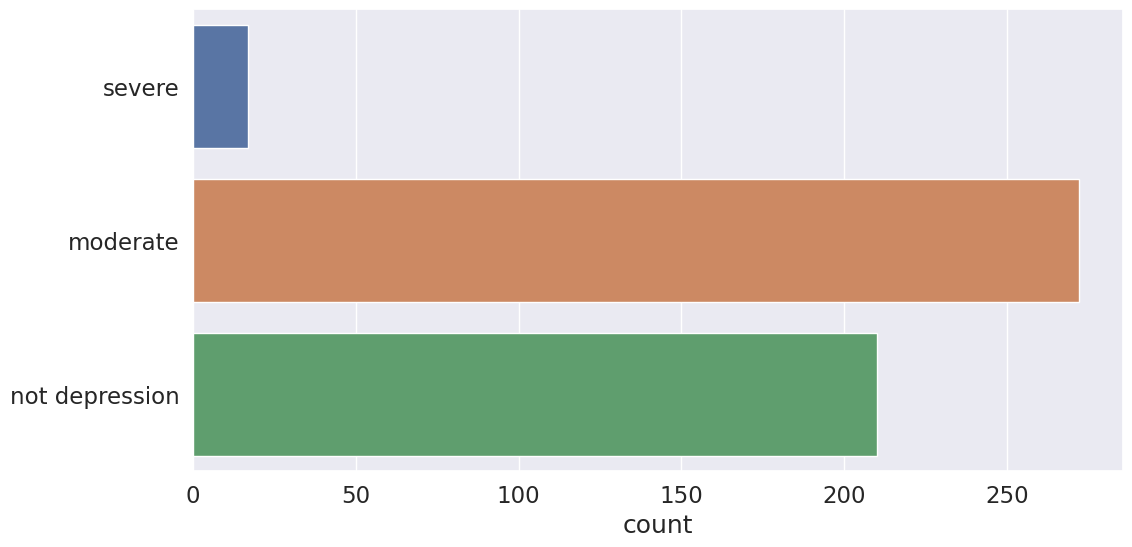

In [78]:
sns.countplot(y =le.inverse_transform(y_preds))

In [79]:
len(y_ids)

499

In [80]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['severe', 'moderate', 'moderate', 'severe', 'moderate', 'moderate',
       'severe', 'moderate', 'moderate', 'not depression', 'severe',
       'moderate', 'moderate', 'not depression', 'not depression',
       'moderate', 'not depression', 'not depression', 'moderate',
       'moderate', 'moderate', 'not depression', 'not depression',
       'not depression', 'not depression', 'not depression',
       'not depression', 'not depression', 'not depression',
       'not depression', 'not depression', 'moderate', 'not depression',
       'moderate', 'not depression', 'moderate', 'moderate',
       'not depression', 'moderate', 'not depression', 'not depression',
       'moderate', 'not depression', 'moderate', 'moderate', 'moderate',
       'not depression', 'moderate', 'moderate', 'moderate', 'severe',
       'not depression', 'moderate', 'moderate', 'not depression',
       'moderate', 'moderate', 'moderate', 'not depression',
       'not depression', 'severe', 'severe', 'moderate

In [81]:
len(y_pred)

499

In [82]:
test_labels

array(['moderate', 'severe', 'moderate', 'moderate', 'moderate',
       'moderate', 'moderate', 'severe', 'moderate', 'moderate',
       'moderate', 'not depression', 'moderate', 'moderate', 'moderate',
       'moderate', 'not depression', 'not depression', 'not depression',
       'not depression', 'not depression', 'moderate', 'not depression',
       'moderate', 'not depression', 'moderate', 'not depression',
       'moderate', 'severe', 'moderate', 'moderate', 'not depression',
       'not depression', 'moderate', 'moderate', 'severe', 'moderate',
       'moderate', 'moderate', 'moderate', 'severe', 'moderate',
       'moderate', 'not depression', 'severe', 'moderate', 'moderate',
       'severe', 'moderate', 'moderate', 'moderate', 'moderate',
       'moderate', 'severe', 'severe', 'severe', 'moderate', 'moderate',
       'moderate', 'moderate', 'not depression', 'moderate', 'moderate',
       'moderate', 'moderate', 'moderate', 'not depression', 'moderate',
       'severe', 'mode

In [83]:
len(y_preds)

499

## Creating Submission DataFrame

In [84]:


df_new = pd.DataFrame({
    'id':y_ids,
    'labels':le.inverse_transform(y_preds)
})

In [85]:

test_df['id'] = test_df.index

In [86]:
df_new

,id,labels
0,296,severe
1,306,moderate
2,314,moderate
3,319,severe
4,323,moderate
...,...,...
494,467,moderate
495,494,moderate
496,9,not depression
497,45,moderate


In [87]:
test_df

,Pid,Text data,Label,id
0,test_id_1,"This is me. Don鈥檛 get me wrong, it鈥檚 better th...",moderate,0
1,test_id_2,I hate that people don鈥檛 understand that i don...,severe,1
2,test_id_3,"But here I am, 24 years old man and doing exac...",moderate,2
3,test_id_4,I鈥檓 trapped inside. Does anyone else get that ...,moderate,3
4,test_id_5,I read a lot of posts on here of people strugg...,moderate,4
...,...,...,...,...
494,test_id_495,I'm 14\nmy mom doesn't take my mental health s...,severe,494
495,test_id_496,I was quite shocked at their reactions. I sort...,moderate,495
496,test_id_497,Lying on my bed..... fantasising another life ...,not depression,496
497,test_id_498,"I was bullied in elementary school, and I alwa...",moderate,497


In [88]:
df_f = pd.merge(test_df,df_new,on = 'id')
df_f

,Pid,Text data,Label,id,labels
0,test_id_1,"This is me. Don鈥檛 get me wrong, it鈥檚 better th...",moderate,0,not depression
1,test_id_2,I hate that people don鈥檛 understand that i don...,severe,1,moderate
2,test_id_3,"But here I am, 24 years old man and doing exac...",moderate,2,not depression
3,test_id_4,I鈥檓 trapped inside. Does anyone else get that ...,moderate,3,moderate
4,test_id_5,I read a lot of posts on here of people strugg...,moderate,4,moderate
...,...,...,...,...,...
494,test_id_495,I'm 14\nmy mom doesn't take my mental health s...,severe,494,moderate
495,test_id_496,I was quite shocked at their reactions. I sort...,moderate,495,not depression
496,test_id_497,Lying on my bed..... fantasising another life ...,not depression,496,moderate
497,test_id_498,"I was bullied in elementary school, and I alwa...",moderate,497,moderate


In [89]:
df_f = df_f[['Pid','labels']]
final_label=df_f['labels']

In [90]:
final_label

0      not depression
1            moderate
2      not depression
3            moderate
4            moderate
            ...      
494          moderate
495    not depression
496          moderate
497          moderate
498    not depression
Name: labels, Length: 499, dtype: object

In [91]:
print(classification_report(test_labels, final_label, target_names=class_names))

                precision    recall  f1-score   support

      moderate       0.58      0.58      0.58       275
non depression       0.40      0.61      0.48       135
        severe       0.65      0.12      0.21        89

      accuracy                           0.51       499
     macro avg       0.54      0.44      0.42       499
  weighted avg       0.54      0.51      0.49       499



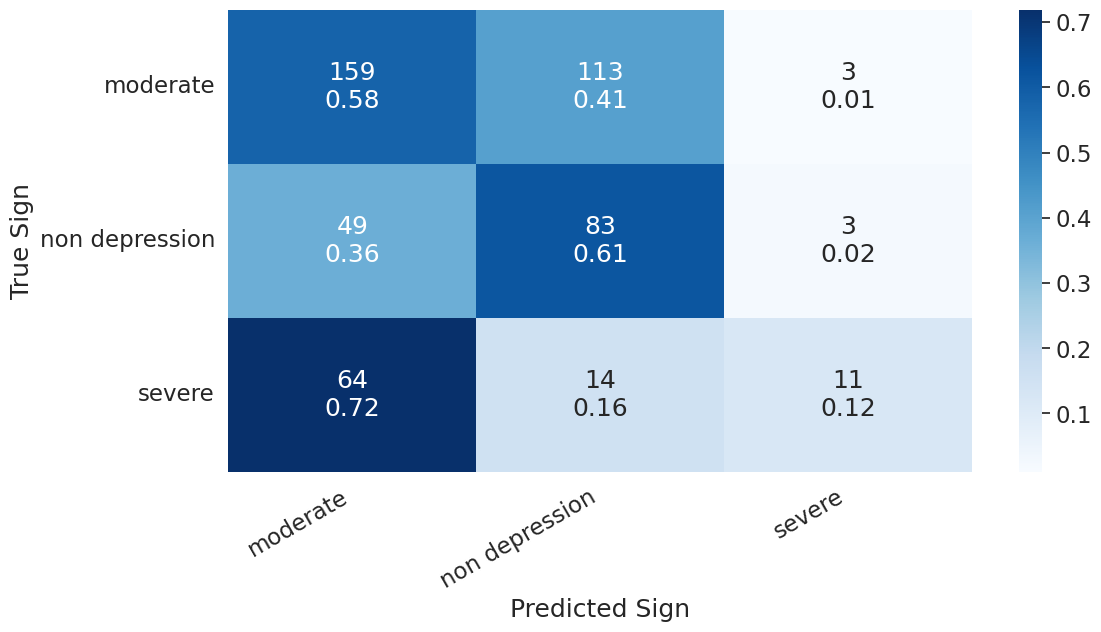

In [92]:
cm = confusion_matrix(test_labels, final_label)
show_confusion_matrix(cm, class_names)